# How Lensed UMAP works

This notebook demonstrates three functions for filtering UMAP graphs to
efficiently explore data from flexible perspective. 

In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import pandas as pd
import lensed_umap as lu
from umap import UMAP

from lib.plotting import *
configure_matplotlib()

import warnings
warnings.filterwarnings("ignore", lineno=151, module=r"sklearn.*")

## Demonstration data

We use a simple dataset for this demonstration. Each point has a 2D position and
an additional signal-value, shown below. The points form an interesting
structure, with one loop and four flares sticking out. Each flare has a signal
local minimum and maximum towards its center.

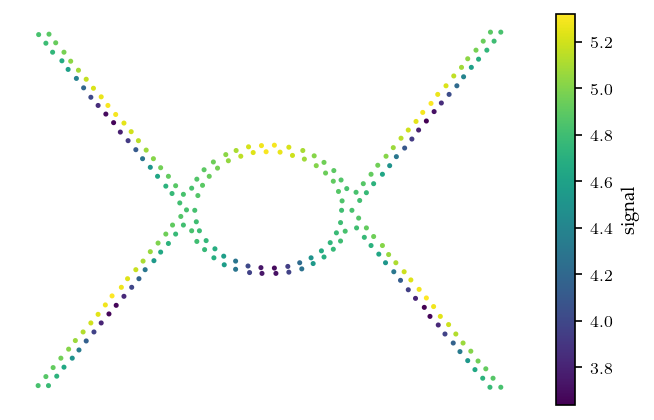

In [21]:
df = pd.read_csv("./data/five_circles.csv", header=0)
lens = np.log(df.hue)

sized_fig(1)
plt.scatter(df.x, df.y, 2, lens, cmap="viridis")
plt.axis("off")
plt.colorbar(label='signal')
plt.show()

## Default UMAP

Exploration starts from a normal UMAP model. In some cases, time can be saved by
only constructing UMAP's graph and leaving computing the 2D layout for later. In
this example, we reduce the repulsion strength in the 2D layout to ensure the
loop remains intact. Otherwise, the process is quite normal.

Constructed graph with 3408 edges


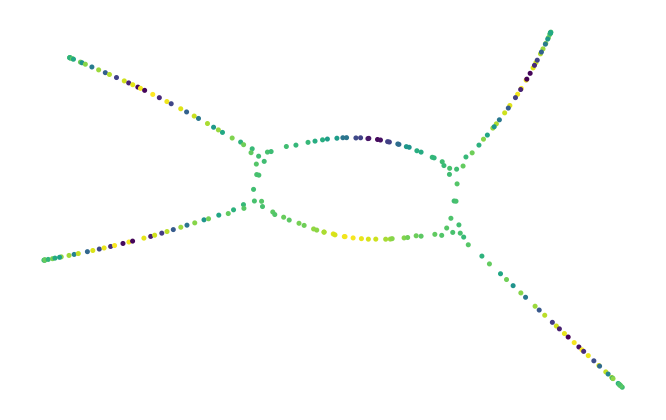

In [22]:
projector = UMAP(
    repulsion_strength=0.1,  # To avoid tears in projection that
    negative_sample_rate=2,  # are not in the modelled graph!
).fit(df[["x", "y"]])
print(f"Constructed graph with {projector.graph_.size} edges")

sized_fig(1)
x, y = lu.extract_embedding(projector)
plt.scatter(x, y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()

## Global Lens

The first filter function is `apply_lens`. This function takes a fitted UMAP
object and returns a (shallow) copy of that object with a new `graph_` and
`embedding_` attributes. To apply the filter, the function discretizes the given
1D signal into segments. Then, the graph is filtered to keep only edges that
cross at most one segment boundary. Finally, the layout is updated for the new
graph.

The cell below demonstrates the function in action. Notice how the four flares
became circles, separating the local extrema from each other.

Constructed graph with 2202 edges


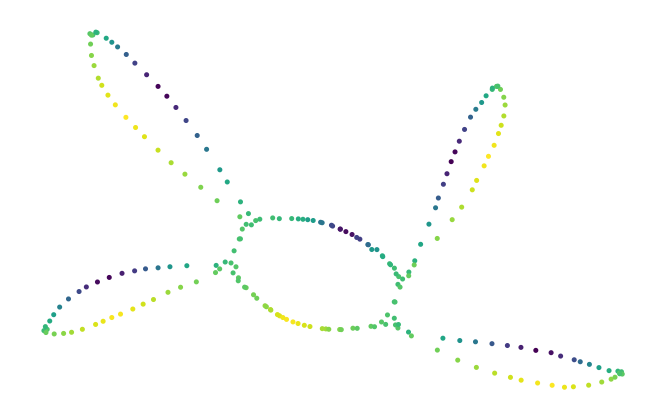

In [23]:
lensed = lu.apply_lens(projector, lens, resolution=6, discretization="balanced")
print(f"Constructed graph with {lensed.graph_.size} edges")

sized_fig(1)
x, y = lu.extract_embedding(lensed)
plt.scatter(x, y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()

This function supports two kinds discretization strategies: `regular` and
`balanced`. 

- Regular is the default and creates equally sized segments. With
regular segments, the filter reduces to a global filter-value-difference
threshold that removes all edges with a filter-value-difference larger than the
one segment width.
- Balanced creates segments that contain the same number of points (except the
last one may be slightly larger than the others). As a consequence, the
filter-value-difference threshold varies with the filter-distribution's density:
for uncommon filter-values the threshold is higher and for common filter-values
the threshold is smaller.

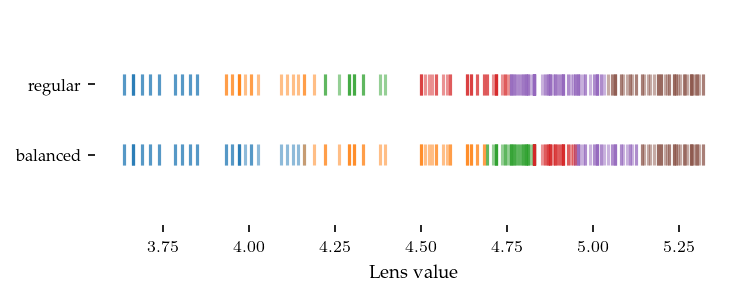

In [24]:
def scatter_segments(projector, lens, y, strategy):
    colors = lu.apply_lens(
        projector,
        lens,
        resolution=6,
        discretization=strategy,
        skip_embedding=True,
        ret_bins=True,
    )[1]
    plt.scatter(
        lens,
        np.repeat(y, len(x)),
        100,
        colors,
        marker="|",
        alpha=0.5,
        cmap="tab10",
        vmin=0,
        vmax=10,
    )


sized_fig(1, 1/3)
scatter_segments(projector, lens, 1, "regular")
scatter_segments(projector, lens, 0, "balanced")
plt.xlabel("Lens value")
plt.ylim([-1, 2])
plt.yticks([0, 1])
plt.gca().set_yticklabels(["balanced", "regular"])
plt.show()

## Global Mask

The second function is `apply_mask`. This function takes two UMAP models:
`projector` and `masker`. Then, it creates a (shallow) copy of `projector` and
updates the graph keeping only the edges that also exist in `masker`. This can
be seen as an intersection, but the edges keep `projector`'s weights! Finally,
the 2D layout is updated for the new graph. To save some compute cost, `masker`
can be fitted with `transform_mode="graph"`, which skips the 2D layout step.

Like the previous function, this strategy can be reduced to a varying
filter-distance threshold. Here, that threshold is expressed as the number of
neighbours to keep in the filter-dimensions. As a consequence, `masker`'s
`n_neighbor` value may need to be quite big to avoid removing too many edges,
which can be expensive to compute. Different from the global lens, this strategy
is not limited to a 1D lens dimension. Instead it uses anything that UMAP
accepts.

Constructed graph with 2576 edges


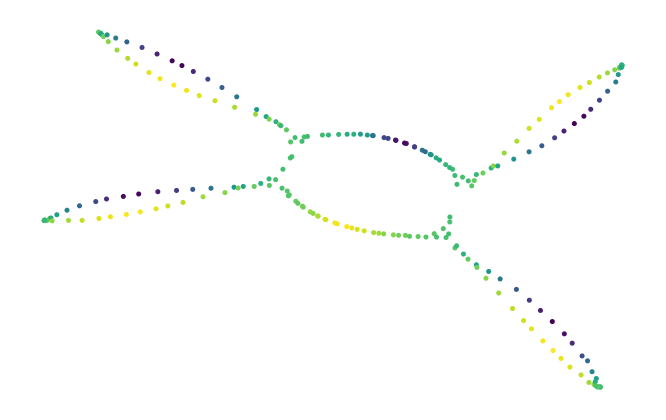

In [25]:
masker = UMAP(n_neighbors=150, transform_mode="graph").fit(df.hue.to_numpy()[None].T)
lensed = lu.apply_mask(projector, masker)
print(f"Constructed graph with {lensed.graph_.size} edges")

sized_fig(1)
x, y = lu.extract_embedding(lensed)
plt.scatter(x, y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()

## Local Mask

The last function is `apply_local_mask`. This function takes a UMAP model and
returns a (shallow) copy with updated graph and 2D layout. The function first
computes a distance in the filter dimensions for each UMAP model's edge. Then, the
closest `n_neighbors` edges are kept for each point (with ties broken by the
edge's strength). Like with the global mask, edges keep their initial weights.
Finally, the 2D layout is updated. 

This strategies does not reduce to a global threshold. Instead, the threshold
varies with the spread of filter-values across the initial UMAP manifold. 

This strategy's parameters are quite intuitive. They directly specify how many
edges to keep. The other strategies indirectly specify which edges to remove,
which can be more difficult to reason about.


Constructed graph with 1346 edges


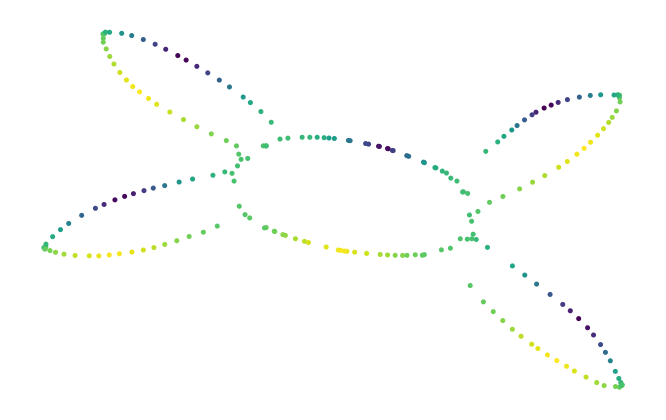

In [26]:
lensed = lu.apply_local_mask(projector, df.hue)
print(f"Constructed graph with {lensed.graph_.size} edges")

sized_fig(1)
x, y = lu.extract_embedding(lensed)
plt.scatter(x, y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()